Processing α = 0.5
Processing α = 1.0
Processing α = 2.0
Processing α = 3.0
Processing α = 4.0
Processing α = 5.0
Processing α = 6.0
Processing α = 7.5


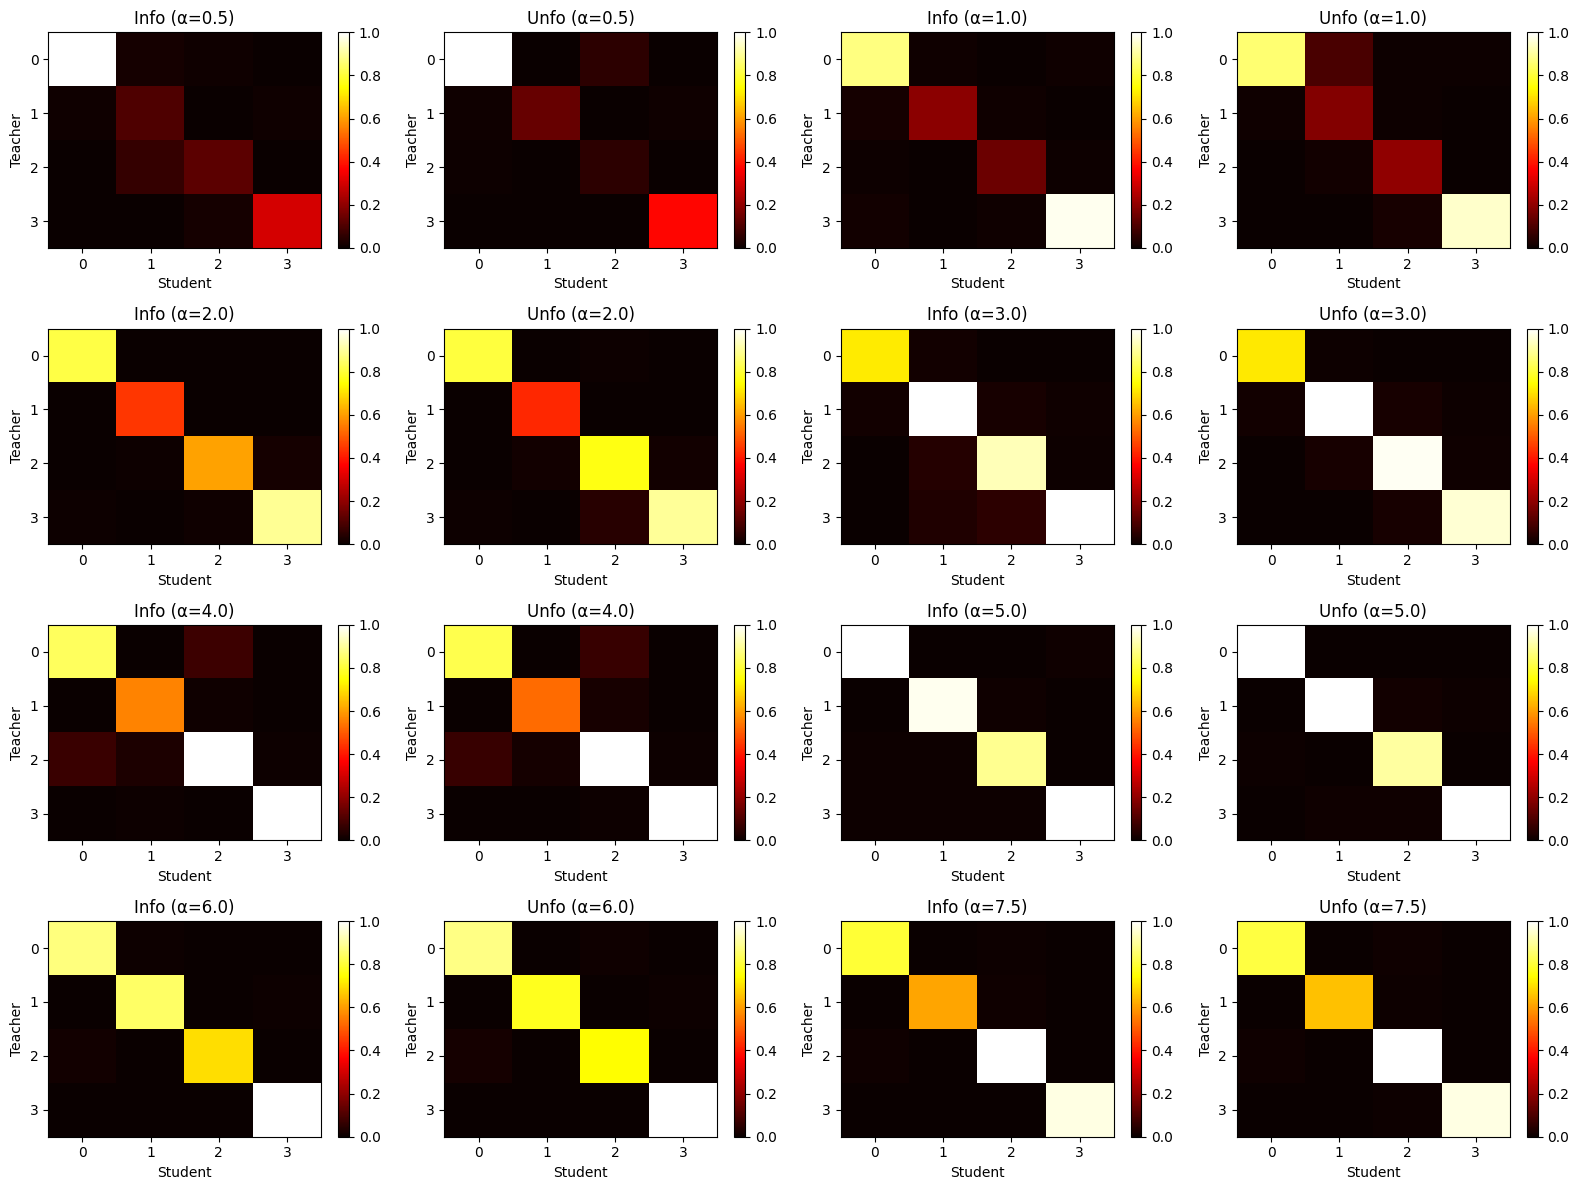

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[1], 'GPU')

import hmc2

from scipy.sparse import csr_array
from scipy.sparse.csgraph import min_weight_full_bipartite_matching as match


# Parameters
d = 150
k = 4
alpha_values = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.5]
Delta = 3
v = tf.constant([-3.0, -1.0, 1.0, 3.0], dtype=tf.float32)
v -= tf.reduce_mean(v)
v /= tf.norm(v)
prior = 'gauss'

#sig = lambda x: (x**2 - 1)/np.sqrt(2.0) + (x**3 - 3*x)/6
sig = lambda x: x + (x**2 - 1)/np.sqrt(2.0) + (x**3 - 3*x)/6
#sig_t = lambda x: tf.sign(x)


params = {
    'step_size': 0.01,
    'num_leapfrog_steps': 10,
    'num_adaptation_steps': 2000,
    'num_post_adapt_steps': 0
}

# subplots for all alpha values

n_1 = len(alpha_values)
assert n_1 <= 8, "You can only plot up to 8 alpha values in a 4x4 grid (2 plots per alpha)."

fig, axes = plt.subplots(4, 4, figsize=(16, 12), tight_layout=True)  # 4x4 grid for visibility
axes = axes.reshape(4, 4)  # Ensure it's in row×col format

for i, alpha in enumerate(alpha_values):
    print(f"Processing α = {alpha}")
    
    # Generate data
    W0, X, Y, v = hmc2.data_generate(d, k, alpha, Delta, sig, v)
    W_ = tf.random.normal((k, d), dtype=tf.float32)
    
    # Posterior sampling
    Ws_unfo = hmc2.hmc(params, W_, X, Y, v, k, alpha, Delta, sig, show_acceptance_rate=False, show_adaptation_steps=True)
    Ws_info = hmc2.hmc(params, W0, X, Y, v, k, alpha, Delta, sig, show_acceptance_rate=False, show_adaptation_steps=True)

    # Final samples
    Wi = Ws_info[-1]
    Wu = Ws_unfo[-1]

    # Compute alignment matrices
    Si = (W0 @ tf.transpose(Wi) / d).numpy()
    Su = (W0 @ tf.transpose(Wu) / d).numpy()

    # Row and column indices in 4x4 grid
    row, col_base = divmod(i, 2)
    col = 2 * col_base

    # Plot informative
    ax1 = axes[row, col]
    im1 = ax1.imshow(Si**2, cmap='hot', aspect='auto', vmin=0, vmax=1)
    ax1.set_title(f'Info (α={alpha})')
    ax1.set_xlabel('Student')
    ax1.set_ylabel('Teacher')
    #fig.colorbar(im1, ax=ax1, shrink=0.7)
    plt.colorbar(im1, ax=ax1)

    # Plot uninformative
    ax2 = axes[row, col + 1]
    im2 = ax2.imshow(Su**2, cmap='hot', aspect='auto', vmin=0, vmax=1)
    ax2.set_title(f'Unfo (α={alpha})')
    ax2.set_xlabel('Student')
    ax2.set_ylabel('Teacher')
    #fig.colorbar(im2, ax=ax2, shrink=0.7)
    plt.colorbar(im2, ax=ax2)

plt.subplots_adjust(top=0.92)
#plt.savefig("Overlap_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
alpha = alpha_values[-1]
test_unfo =  hmc2.test_error(Ws_unfo, W0, v, sig, ntest=10000)
test_info =  hmc2.test_error(Ws_info, W0, v, sig, ntest=10000)

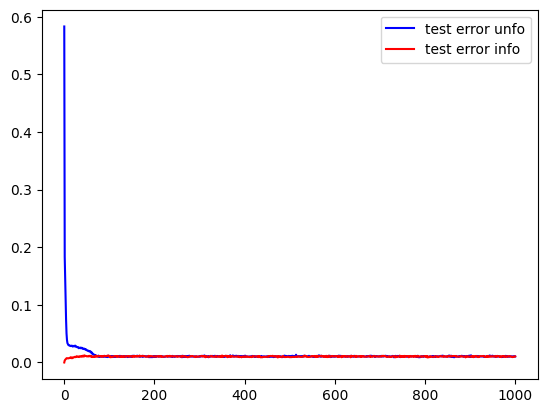

In [9]:
plt.plot(test_unfo, label='test error unfo', color='b')
plt.plot(test_info, label='test error info', color='r')
plt.legend()
plt.show()

In [10]:
print(f"Final test error (unfo): {test_unfo[-1]}")
print(f"Final test error (info): {test_info[-1]}")

Final test error (unfo): 0.010367506183683872
Final test error (info): 0.010522957891225815


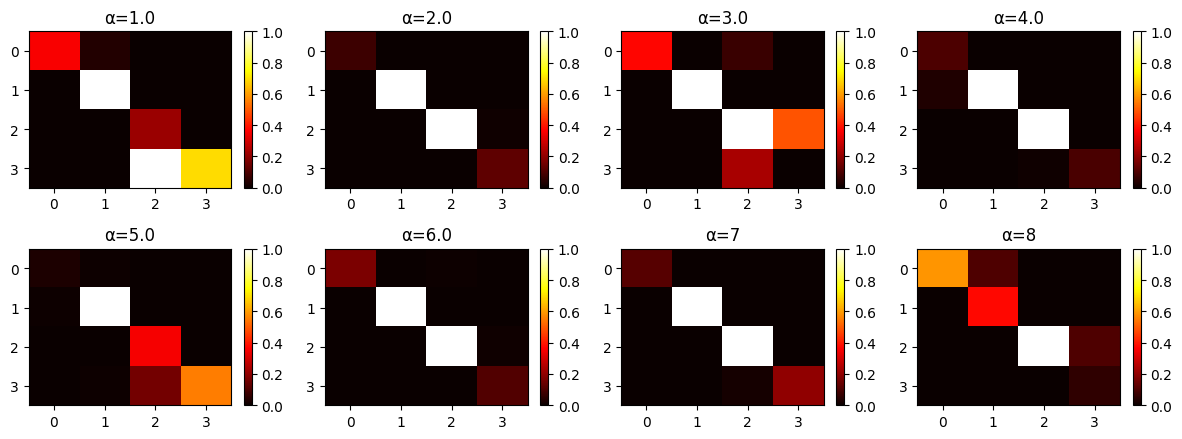

In [14]:


def per(M):
    size, _ = M.shape
    per_index = match(csr_array(M), maximize=True)
    per_matrix = np.zeros((size, size), dtype=int)
    per_matrix[per_index[0], per_index[1]] = 1
    M_ = per_matrix.T @ M
    return M_
    
# tecaher activation
sig_t = lambda x: tf.sign(x)

# ------------------------------
# Data generation (teacher)
# ------------------------------
def data_generate(d, k, alpha, Delta, sig_t, v):
    c_k, c_d = 1/np.sqrt(k), 1/np.sqrt(d)
    n = int(alpha * d**2)
    W0 = tf.random.normal((k, d), dtype=tf.float32)
    X = tf.random.normal((d, n), dtype=tf.float32)
    Z = tf.random.normal((n,), dtype=tf.float32)
    M = sig_t(W0 @ X * c_d)
    Y = tf.tensordot(v, M, axes=1) * c_k + tf.sqrt(Delta) * Z
    return W0, X, Y, v

# ------------------------------
# Student training
# ------------------------------
def train_student(X, Y, k, d, v, Delta, sig, lr=1e-2, steps=1000, track_alignments=False, W0=None):
    c_k, c_d = 1/np.sqrt(k), 1/np.sqrt(d)
    W = tf.Variable(tf.random.normal((k, d), dtype=tf.float32))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    snapshots = []

    for step in range(steps):
        with tf.GradientTape() as tape:
            M = sig(W @ X * c_d)
            Y_hat = tf.tensordot(v, M, axes=1) * c_k
            loss = tf.reduce_mean((Y_hat - Y)**2) / (2 * Delta)
        grads = tape.gradient(loss, [W])
        optimizer.apply_gradients(zip(grads, [W]))

        if track_alignments and step % 100 == 0:
            S = (W0 @ tf.transpose(W) / d).numpy()
            snapshots.append(S)

    if track_alignments:
        return W.numpy(), snapshots
    else:
        return W.numpy()

# ------------------------------
# Experiment setup
# ------------------------------
d, k = 150, 4
alpha_values = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7, 8]
Delta = 1.0
v = tf.constant([-3, -1, 1, 3], dtype=tf.float32)
v = v - tf.reduce_mean(v)
v /= tf.norm(v)

sig = lambda x: x + (x**2 - 1)/np.sqrt(2.0) + (x**3 - 3*x)/6
alignments = []
alpha_6_snapshots = []

for alpha in alpha_values:
    #print(f"Training for alpha = {alpha}")
    W0, X, Y, _ = data_generate(d, k, alpha, Delta, sig, v)

    if alpha == 6:
        W_student, alpha_6_snapshots = train_student(
            X, Y, k, d, v, Delta, sig, track_alignments=True, W0=W0)
    else:
        W_student = train_student(X, Y, k, d, v, Delta, sig)

    S = W0 @ tf.transpose(W_student) / d
    #print(f"Max S entry for alpha={alpha}: {np.max(S)}")
    alignments.append(S.numpy()**2)

# ------------------------------
# Plotting
# ------------------------------
fig, axes = plt.subplots(2, 4, figsize=(12, 4.5), tight_layout=True)
axes = axes.flatten()

for i, (S, alpha) in enumerate(zip(alignments, alpha_values)):
    ax = axes[i]
    aligned = per(S)
    im = ax.imshow(aligned**2, cmap='hot', aspect='auto', vmin=0, vmax=1)
    ax.set_title(f"α={alpha}")
    plt.colorbar(im, ax=ax)

#plt.savefig("alignment_matrices_fixed.png", dpi=300, bbox_inches='tight')
plt.show()


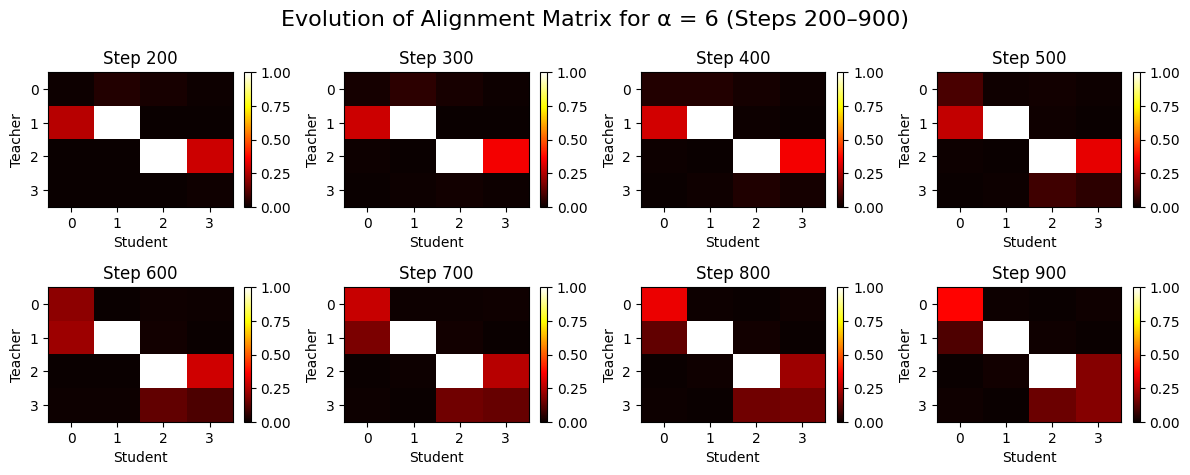

In [9]:
# Plot evolution of alignment matrix for alpha = 6 (from step 200 to 1000)
start_index = 2  # step 200 is the 3rd snapshot (0-indexed: 0,100,200 → index2)
end_index = 10   # step 900 is the 10th snapshot (0-indexed: 900 is index9)

selected_snapshots = alpha_6_snapshots[start_index:end_index]  # 8 snapshots (200-900)
num_snapshots = len(selected_snapshots)

fig, axes = plt.subplots(2, 4, figsize=(12, 4.8), tight_layout=True)
axes = axes.flatten()

for i, S in enumerate(selected_snapshots):
    ax = axes[i]
    aligned = per(S)
    step_number = (start_index + i) * 100  # Calculate actual step (200, 300, ..., 900)
    im = ax.imshow(aligned**2, cmap='hot', aspect='auto', vmin=0, vmax=1)
    ax.set_title(f"Step {step_number}")
    ax.set_xlabel("Student")
    ax.set_ylabel("Teacher")
    plt.colorbar(im, ax=ax)

# Hide any unused subplots (we have exactly 8 snapshots so this won't execute)
for j in range(num_snapshots, 8):
    fig.delaxes(axes[j])

#plt.suptitle("Evolution of Alignment Matrix for α = 6 (Steps 200–900)", fontsize=16)
#plt.savefig("alignment_evolution_alpha6_200_900.png", dpi=300, bbox_inches='tight')
plt.show()

In [6]:
#Bayes-optimal Generalization Error from Overlap Matrix
import tensorflow as tf
import numpy as np

def bayes_generalization_error_tf(q_np, N=100000):
    """
    TensorFlow version of Bayes-optimal generalization error computation
    for a committee machine with K=4 and non-uniform normalized readout.

    Parameters:
    - q_np: (4x4 NumPy array) overlap matrix
    - N: number of Monte Carlo samples

    Returns:
    - epsilon_g: generalization error estimate (float)
    """
    K = 4  # number of hidden units

    # Readout weights (non-uniform, zero-mean, unit-norm)
    v = tf.constant([-3.0, -1.0, 1.0, 3.0], dtype=tf.float32)
    v = v - tf.reduce_mean(v)
    v = v / tf.norm(v)

    # Convert overlap matrix to TensorFlow tensor
    q = tf.convert_to_tensor(q_np, dtype=tf.float32)

    # Check positive semidefiniteness (warn but continue)
    eigvals = tf.linalg.eigvalsh(q)
    if tf.reduce_any(eigvals < 0):
        tf.print("Warning: q is not positive semidefinite.")

    # Compute noise standard deviation per unit
    q_squared_sum = tf.reduce_sum(tf.square(q), axis=1)
    noise_std = tf.sqrt(tf.maximum(1.0 - q_squared_sum, 0.0))  # shape (4,)

    # Sample standard Gaussian noise x ∈ R^8
    x = tf.random.normal((N, 2*K), dtype=tf.float32)
    x1 = x[:, :K]   # for σ(x_l)
    x2 = x[:, K:]   # for noise in h_l(x)

    # Teacher output: sign of vᵀ sign(x1)
    sign_x = tf.sign(x1)
    teacher_vote = tf.sign(tf.tensordot(sign_x, v, axes=1))  # shape (N,)

    # Student pre-activations h = q x1 + noise
    h = tf.matmul(x1, tf.transpose(q)) + x2 * noise_std
    sign_h = tf.sign(h)
    student_vote = tf.sign(tf.tensordot(sign_h, v, axes=1))  # shape (N,)

    # Agreement
    agreement = tf.cast(tf.equal(teacher_vote, student_vote), tf.float32)
    accuracy = tf.reduce_mean(agreement)
    epsilon_g = 0.5 * (1.0 - accuracy)

    return float(epsilon_g)


In [51]:
# Define q = q_d * I + q_a * vv^T   #not run
K = 4
v_vec = np.ones(K) / K
q_d = 0.2
q_a = 0.6
q = q_d * np.eye(K) + q_a * np.outer(v_vec, v_vec)

# Compute generalization error
eps_g = bayes_generalization_error_tf(q)
print(f"Bayes-optimal generalization error: {eps_g:.5f}")


Bayes-optimal generalization error: 0.30597


In [ ]:
#alphas = np.linspace(0.5, 7.5, 20)
alphas = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.5]
q_list = [run_state_evolution(alpha, K=4) for alpha in alphas]
eps_g_vals = [bayes_generalization_error_tf(q) for q in q_list]


In [ ]:
plt.plot(alphas, eps_g_vals, label="Bayes-optimal ε_g")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"Generalization error $\epsilon_g$")
plt.grid(True)
plt.legend()
plt.show()


Running state evolution for alpha = 0.5
Iteration 0, Δ = 0.00020
Iteration 1, Δ = 0.00001

Running state evolution for alpha = 1.0
Iteration 0, Δ = 0.00020
Iteration 1, Δ = 0.00001

Running state evolution for alpha = 2.0
Iteration 0, Δ = 0.00020
Iteration 1, Δ = 0.00001

Running state evolution for alpha = 3.0
Iteration 0, Δ = 0.00020
Iteration 1, Δ = 0.00001

Running state evolution for alpha = 4.0
Iteration 0, Δ = 0.00020
Iteration 1, Δ = 0.00001

Running state evolution for alpha = 5.0
Iteration 0, Δ = 0.00020
Iteration 1, Δ = 0.00001

Running state evolution for alpha = 6.0
Iteration 0, Δ = 0.00020
Iteration 1, Δ = 0.00001

Running state evolution for alpha = 7.5
Iteration 0, Δ = 0.00020
Iteration 1, Δ = 0.00001


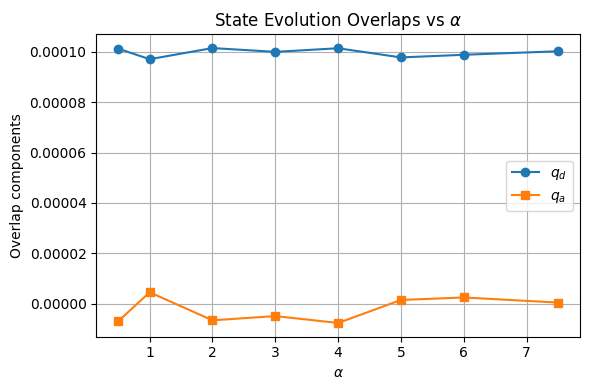

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Polynomial activation function
def poly_activation(x):
    return x + (tf.square(x) - 1.0) / tf.sqrt(2.0) + (tf.pow(x, 3) - 3.0 * x) / 6.0

# Compute P_out(y | xi) using binary output
# def compute_Zy_tf(y, xi, q, Q0, N=1000, v=None):
#     K = tf.shape(q)[0]
#     if v is None:
#         v = tf.ones(K, dtype=tf.float32) / tf.sqrt(tf.cast(K, tf.float32))
#     Z = tf.random.normal((N, K), dtype=tf.float32)
#     sqrt_diff = tf.linalg.cholesky(Q0 - q + 1e-8 * tf.eye(K))
#     sqrt_q = tf.linalg.cholesky(q + 1e-8 * tf.eye(K))
#     z_eff = tf.matmul(Z, sqrt_diff, transpose_b=True) + tf.matmul(tf.expand_dims(xi, 0), sqrt_q, transpose_b=True)
#     h = poly_activation(z_eff)
#     sign_vote = tf.sign(tf.reduce_sum(h * v, axis=1))
#     match = tf.cast(tf.equal(sign_vote, y), tf.float32)
#     return tf.reduce_mean(match) + 1e-10
def compute_Zy_tf(y, xi, q, Q0, N=1000, v=None):
    K = tf.shape(q)[0]
    if v is None:
        v = tf.ones(K, dtype=tf.float32) / tf.sqrt(tf.cast(K, tf.float32))
    Z = tf.random.normal((N, K), dtype=tf.float32)
    sqrt_diff = tf.linalg.cholesky(Q0 - q + 1e-8 * tf.eye(K))
    sqrt_q = tf.linalg.cholesky(q + 1e-8 * tf.eye(K))
    z_eff = tf.matmul(Z, sqrt_diff, transpose_b=True) + tf.matmul(tf.expand_dims(xi, 0), sqrt_q, transpose_b=True)

    h = poly_activation(z_eff)
    logits = tf.reduce_sum(h * v, axis=1)
    # Use sigmoid likelihood to enable differentiation
    probs = tf.sigmoid(y * logits)
    return tf.reduce_mean(probs) + 1e-10

def gradient_log_Zy_tf(y, xi, q, Q0, N=1000, v=None):
    xi = tf.convert_to_tensor(xi, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(xi)
        log_Z = tf.math.log(compute_Zy_tf(y, xi, q, Q0, N, v))
    grad = tape.gradient(log_Z, xi)
    if grad is None:
        raise ValueError("Gradient is None: check differentiability of compute_Zy_tf")
    return grad



# # Gradient ∇_xi log Z_y(ξ)
# def gradient_log_Zy_tf(y, xi, q, Q0, N=1000, v=None):
#     xi = tf.convert_to_tensor(xi, dtype=tf.float32)
#     with tf.GradientTape() as tape:
#         tape.watch(xi)
#         log_Z = tf.math.log(compute_Zy_tf(y, xi, q, Q0, N, v))
#     return tape.gradient(log_Z, xi)

# Posterior mean estimator: E[w | xi]
def posterior_mean_estimate_tf(xi, hat_q, N_samples=10000):
    K = tf.shape(xi)[0]
    hat_q = hat_q + 1e-8 * tf.eye(K)
    sqrt_hat_q = tf.linalg.cholesky(hat_q)
    w = tf.random.normal((N_samples, K), dtype=tf.float32)
    exps = -0.5 * tf.reduce_sum(w * tf.matmul(w, hat_q), axis=1) + tf.reduce_sum(w * tf.matmul(tf.expand_dims(xi, 0), hat_q), axis=1)
    weights = tf.exp(exps - tf.reduce_max(exps))
    weights /= tf.reduce_sum(weights)
    return tf.reduce_sum(w * tf.expand_dims(weights, axis=1), axis=0)

# Update q
def update_q_tf(hat_q, K=4, N=5000):
    xi_samples = tf.random.normal((N, K), dtype=tf.float32)
    w_means = tf.stack([posterior_mean_estimate_tf(xi, hat_q) for xi in xi_samples])
    return tf.matmul(w_means, w_means, transpose_a=True) / tf.cast(N, tf.float32)

# Update hat_q
def update_hat_q_tf(q, Q0, alpha, K=4, N=1000, v=None):
    xi_samples = tf.random.normal((N, K), dtype=tf.float32)
    y_vals = [-1.0, 1.0]
    hat_q = tf.zeros((K, K), dtype=tf.float32)
    for xi in xi_samples:
        for y in y_vals:
            grad = gradient_log_Zy_tf(y, xi, q, Q0, N=500, v=v)
            hat_q += tf.tensordot(grad, grad, axes=0)
    return alpha * hat_q / (N * len(y_vals))

# Main state evolution loop
def run_state_evolution_tf(alpha, K=4, max_iter=50, tol=1e-4, v=None):
    q = tf.zeros((K, K), dtype=tf.float32)
    Q0 = tf.eye(K, dtype=tf.float32)
    for t in range(max_iter):
        hat_q = update_hat_q_tf(q, Q0, alpha, K, v=v)
        q_next = update_q_tf(hat_q, K)
        delta = tf.norm(q_next - q)
        print(f"Iteration {t}, Δ = {delta.numpy():.5f}")
        if delta < tol:
            break
        q = q_next
    return q

# Normalized readout vector
v = tf.constant([-3.0, -1.0, 1.0, 3.0], dtype=tf.float32)
v -= tf.reduce_mean(v)
v /= tf.norm(v)

# Alpha values to sweep
alpha_values = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.5]

# Store overlap components
q_list = []
qd_values = []
qa_values = []

for alpha in alpha_values:
    print(f"\nRunning state evolution for alpha = {alpha}")
    q_alpha = run_state_evolution_tf(alpha=alpha, v=v)
    q_np = q_alpha.numpy()
    q_list.append(q_np)

    # Decompose q = q_d * I + q_a * vv^T
    v_np = v.numpy()
    v_outer = np.outer(v_np, v_np)
    q_a = np.mean((q_np - np.diag(np.diag(q_np))) / v_outer)
    q_d = np.mean(np.diag(q_np) - q_a * v_np**2)

    qa_values.append(q_a)
    qd_values.append(q_d)

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(alpha_values, qd_values, label=r"$q_d$", marker='o')
plt.plot(alpha_values, qa_values, label=r"$q_a$", marker='s')
plt.xlabel(r"$\alpha$")
plt.ylabel("Overlap components")
plt.title(r"State Evolution Overlaps vs $\alpha$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf

def poly_activation_tf(x):
    return x + (tf.square(x) - 1.0) / tf.sqrt(2.0) + (tf.pow(x, 3) - 3.0 * x) / 6.0

def bayes_generalization_error_poly(q_np, N=100_000):
    """
    Bayes-optimal generalization error using polynomial activation
    for a committee machine with K=4 and non-uniform normalized readout.

    Parameters:
    - q_np: (4x4 NumPy array) overlap matrix
    - N: number of Monte Carlo samples

    Returns:
    - epsilon_g: generalization error estimate (float)
    """
    K = 4
    v = tf.constant([-3.0, -1.0, 1.0, 3.0], dtype=tf.float32)
    v -= tf.reduce_mean(v)
    v /= tf.norm(v)

    q = tf.convert_to_tensor(q_np, dtype=tf.float32)

    eigvals = tf.linalg.eigvalsh(q)
    if tf.reduce_any(eigvals < 0):
        tf.print("Warning: q is not positive semidefinite.")

    q_squared_sum = tf.reduce_sum(tf.square(q), axis=1)
    noise_std = tf.sqrt(tf.maximum(1.0 - q_squared_sum, 0.0))

    x = tf.random.normal((N, 2 * K), dtype=tf.float32)
    x1 = x[:, :K]
    x2 = x[:, K:]

    # Teacher: apply polynomial activation to Gaussian input
    h_teacher = poly_activation_tf(x1)
    teacher_vote = tf.sign(tf.tensordot(h_teacher, v, axes=1))

    # Student: q x1 + noise, then polynomial activation
    h_student = tf.matmul(x1, tf.transpose(q)) + x2 * noise_std
    h_student = poly_activation_tf(h_student)
    student_vote = tf.sign(tf.tensordot(h_student, v, axes=1))

    agreement = tf.cast(tf.equal(teacher_vote, student_vote), tf.float32)
    accuracy = tf.reduce_mean(agreement)
    epsilon_g = 0.5 * (1.0 - accuracy)

    return float(epsilon_g)


In [ ]:
# Define normalized non-uniform readout vector
v = tf.constant([-3.0, -1.0, 1.0, 3.0], dtype=tf.float32)
v -= tf.reduce_mean(v)
v /= tf.norm(v)

# Run state evolution at α = 2.0
q_star = run_state_evolution_tf(alpha=2.0, v=v)
print("Final overlap matrix q:\n", q_star.numpy())

In [15]:
import tensorflow as tf
import numpy as np

# Polynomial activation
def poly_activation(x):
    return x + (tf.square(x) - 1.0) / tf.sqrt(2.0) + (tf.pow(x, 3) - 3.0 * x) / 6.0

# Posterior mean estimator: E[w | xi]
def posterior_mean_estimate(xi, hat_q, N=5000):
    K = tf.shape(xi)[0]
    L = tf.linalg.cholesky(hat_q + 1e-8 * tf.eye(K))
    w_samples = tf.random.normal((N, K))
    exps = tf.einsum('nk,kl->nl', w_samples, L)
    exps = tf.reduce_sum(exps * xi[None, :], axis=1) - 0.5 * tf.reduce_sum(tf.square(tf.einsum('nk,kl->nl', w_samples, hat_q)), axis=1)
    weights = tf.exp(exps - tf.reduce_max(exps))
    weights /= tf.reduce_sum(weights)
    return tf.reduce_sum(w_samples * weights[:, None], axis=0)

# q update via posterior means
def update_q(hat_q, K=4, N=1000):
    xi_samples = tf.random.normal((N, K))
    w_means = tf.stack([posterior_mean_estimate(xi, hat_q) for xi in xi_samples])
    return tf.matmul(w_means, w_means, transpose_a=True) / tf.cast(N, tf.float32)

# Z_y(ξ) for non-uniform v and polynomial activation
def compute_Zy(y, xi, q, Q0, v, N=1000):
    K = tf.shape(q)[0]
    Z = tf.random.normal((N, K))
    L1 = tf.linalg.cholesky(Q0 - q + 1e-8 * tf.eye(K))
    L2 = tf.linalg.cholesky(q + 1e-8 * tf.eye(K))
    z_eff = tf.matmul(Z, L1, transpose_b=True) + tf.matmul(xi[None, :], L2, transpose_b=True)
    h = poly_activation(z_eff)
    logits = tf.reduce_sum(h * v, axis=1)
    return tf.reduce_mean(tf.sigmoid(y * logits)) + 1e-10

# ∇_xi log Z_y(ξ)
def grad_log_Zy(y, xi, q, Q0, v, N=1000):
    with tf.GradientTape() as tape:
        tape.watch(xi)
        logZ = tf.math.log(compute_Zy(y, xi, q, Q0, v, N))
    return tape.gradient(logZ, xi)

# q̂ update
def update_hat_q(q, Q0, alpha, v, K=4, N=1000):
    xi_samples = tf.random.normal((N, K))
    y_vals = [-1.0, 1.0]
    hat_q = tf.zeros((K, K), dtype=tf.float32)
    for xi in xi_samples:
        for y in y_vals:
            grad = grad_log_Zy(y, xi, q, Q0, v)
            hat_q += tf.tensordot(grad, grad, axes=0)
    return alpha * hat_q / (N * len(y_vals))

# Full SE loop
def run_state_evolution(alpha, v, K=4, max_iter=50, tol=1e-4):
    q = tf.zeros((K, K), dtype=tf.float32)
    Q0 = tf.eye(K, dtype=tf.float32)
    for t in range(max_iter):
        hat_q = update_hat_q(q, Q0, alpha, v, K)
        q_next = update_q(hat_q, K)
        delta = tf.norm(q_next - q)
        print(f"[α={alpha:.2f}] Iter {t}: Δ = {delta.numpy():.5f}")
        if delta < tol:
            break
        q = q_next
    return q



Running SE for α = 0.5


I0000 00:00:1752594093.211149 1231073 cuda_solvers.cc:178] Creating GpuSolver handles for stream 0x27399b50


[α=0.50] Iter 0: Δ = 0.00040
[α=0.50] Iter 1: Δ = 0.00003

Running SE for α = 1.0
[α=1.00] Iter 0: Δ = 0.00041
[α=1.00] Iter 1: Δ = 0.00005

Running SE for α = 2.0
[α=2.00] Iter 0: Δ = 0.00040
[α=2.00] Iter 1: Δ = 0.00006

Running SE for α = 3.0
[α=3.00] Iter 0: Δ = 0.00039
[α=3.00] Iter 1: Δ = 0.00008

Running SE for α = 4.0
[α=4.00] Iter 0: Δ = 0.00041
[α=4.00] Iter 1: Δ = 0.00008

Running SE for α = 5.0
[α=5.00] Iter 0: Δ = 0.00040
[α=5.00] Iter 1: Δ = 0.00010
[α=5.00] Iter 2: Δ = 0.00005

Running SE for α = 6.0
[α=6.00] Iter 0: Δ = 0.00041
[α=6.00] Iter 1: Δ = 0.00012
[α=6.00] Iter 2: Δ = 0.00008

Running SE for α = 7.5
[α=7.50] Iter 0: Δ = 0.00040
[α=7.50] Iter 1: Δ = 0.00015
[α=7.50] Iter 2: Δ = 0.00009


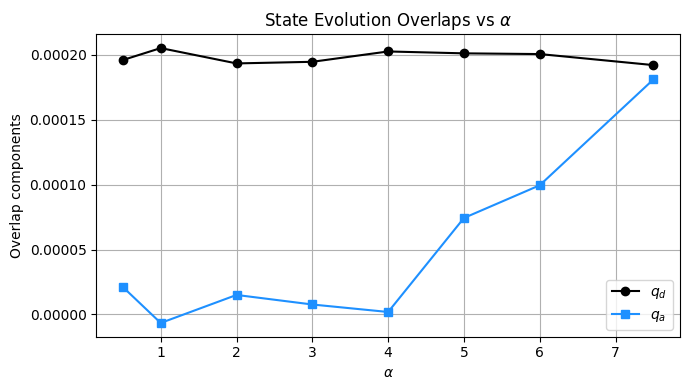

In [16]:
# Define normalized non-uniform readout vector v
v = tf.constant([-3.0, -1.0, 1.0, 3.0], dtype=tf.float32)
v -= tf.reduce_mean(v)
v /= tf.norm(v)

# Alpha sweep values
alpha_values = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.5]

# Storage for q, q_d, q_a
q_list = []
qd_values = []
qa_values = []

for alpha in alpha_values:
    print(f"\nRunning SE for α = {alpha}")
    q_alpha = run_state_evolution(alpha=alpha, v=v)
    q_np = q_alpha.numpy()
    q_list.append(q_np)

    # Extract q_d and q_a from q = q_d I + q_a vv^T
    v_np = v.numpy()
    v_outer = np.outer(v_np, v_np)
    q_a = np.mean((q_np - np.diag(np.diag(q_np))) / v_outer)
    q_d = np.mean(np.diag(q_np) - q_a * v_np**2)

    qa_values.append(q_a)
    qd_values.append(q_d)

# Plot
plt.figure(figsize=(7, 4))
plt.plot(alpha_values, qd_values, label=r"$q_d$", marker='o', color='black')
plt.plot(alpha_values, qa_values, label=r"$q_a$", marker='s', color='dodgerblue')

plt.xlabel(r"$\alpha$")
plt.ylabel("Overlap components")
plt.title("State Evolution Overlaps vs $\\alpha$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
